In [2]:
import pandas as pd
import pandasql
import numpy as np
from pandasql import sqldf
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
pysqldf = lambda q: sqldf(q, globals())

In [3]:
bom_df = pd.read_csv("data/bom.movie_gross.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")
rt_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rt_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
tmdb_df = pd.read_csv("data/tmdb.movies.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")

conn = sqlite3.connect("data/im.db")
imdb_tables = pd.read_sql("""
SELECT name FROM sqlite_master
    WHERE type='table'
""", conn)

movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

# Dataset Selection

Among our datasets, there are two with good budget data: **tn_df** and **bom_df**. tn_df has far more data points than bom_df, which has a studio column but that is irrelevant to our current question.

# Cleaning

Looking at the data types of our dataset below, we see that release date, budget, domestic gross, and worldwide gross are all formatted as strings and need to be converted to integers for analysis. I will re-format these columns to integers and create several new columns for our analysis.

In [4]:
df = tn_df.copy() #Using the copy method so that we don't modify the original dataset
df.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [5]:
#This function will turn a money-formatted string into an integer.
def money_to_int(x):
    x = x[1:]
    split = x.split(",")
    joined = "".join(split)
    integer = int(joined)
    return integer


# Changing budget and gross columns to integer types
df['production_budget'] = df['production_budget'].map(lambda x: money_to_int(x))
df['domestic_gross'] = df['domestic_gross'].map(lambda x: money_to_int(x))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x: money_to_int(x))
df['release_date'] = df['release_date'].map(lambda x: x[-4:]).astype(int)

# Creating the ROI column
df['ROI_percent'] = (df['worldwide_gross'] / df['production_budget'])*100
df['ROI_percent'] = df['ROI_percent'].astype(int)

In [6]:
#Creating the more complicated production tier column
tiers = [500000,
         1000000,
         5000000,
         10000000,
         50000000,
         100000000,
         150000000,
         200000000,
         250000000,
         300000000,
         350000000,
         400000000]

tierstrings = [format(i, ",") for i in tiers]
tierranges = ["< {}".format(tierstrings[0])] + \
             ["{} – {}".format(tierstrings[i], tierstrings[i+1]) for i in range(len(tiers)-1)] + \
             ["> {}".format(tierstrings[-1])]

df['production_budget_tier'] = df['production_budget'].map(lambda x:
                                                                     0 if x < tiers[0] else
                                                                    (1 if x < tiers[1] else 
                                                                    (2 if x < tiers[2] else 
                                                                    (3 if x < tiers[3] else 
                                                                    (4 if x < tiers[4] else
                                                                    (5 if x < tiers[5] else
                                                                    (6 if x < tiers[6] else
                                                                    (7 if x < tiers[7] else
                                                                    (8 if x < tiers[8] else
                                                                    (9 if x < tiers[9] else
                                                                   (10 if x < tiers[10] else
                                                                   (11 if x < tiers[11] else
                                                                    12
                                                                    ))))))))))))

df['production_budget_dollars'] = df['production_budget'].map(lambda x:
                                                                     tierranges[0] if x < tiers[0] else
                                                                    (tierranges[1] if x < tiers[1] else 
                                                                    (tierranges[2] if x < tiers[2] else 
                                                                    (tierranges[3] if x < tiers[3] else 
                                                                    (tierranges[4] if x < tiers[4] else
                                                                    (tierranges[5] if x < tiers[5] else
                                                                    (tierranges[6] if x < tiers[6] else
                                                                    (tierranges[7] if x < tiers[7] else
                                                                    (tierranges[8] if x < tiers[8] else
                                                                    (tierranges[9] if x < tiers[9] else
                                                                   (tierranges[10] if x < tiers[10] else
                                                                   (tierranges[11] if x < tiers[11] else
                                                                    tierranges[12]
                                                                    ))))))))))))

In [7]:
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI_percent,production_budget_tier,production_budget_dollars
0,1,2009,Avatar,425000000,760507625,2776345279,653,12,"> 400,000,000"
1,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,254,12,"> 400,000,000"
2,3,2019,Dark Phoenix,350000000,42762350,149762350,42,11,"350,000,000 – 400,000,000"
3,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,424,10,"300,000,000 – 350,000,000"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,415,10,"300,000,000 – 350,000,000"


# Question One – Scatter Plot: Budget vs. ROI(%)

We have created many new columns and re-formatted the ones we started out with, and now the dataset is more suitable for analysis.

One very important feature of a movie to start out with is the budget. When filmmaking, budgeting is a very important part of it – therefore, it's important to investigate any connections it has to profitability.

Our scatterplot has Budget on the x-axis and ROI on the y-axis. Aside from some minor aesthetic changes,  I also coded a trendline as well as annotated the coefficient of correlation in the top left corner.

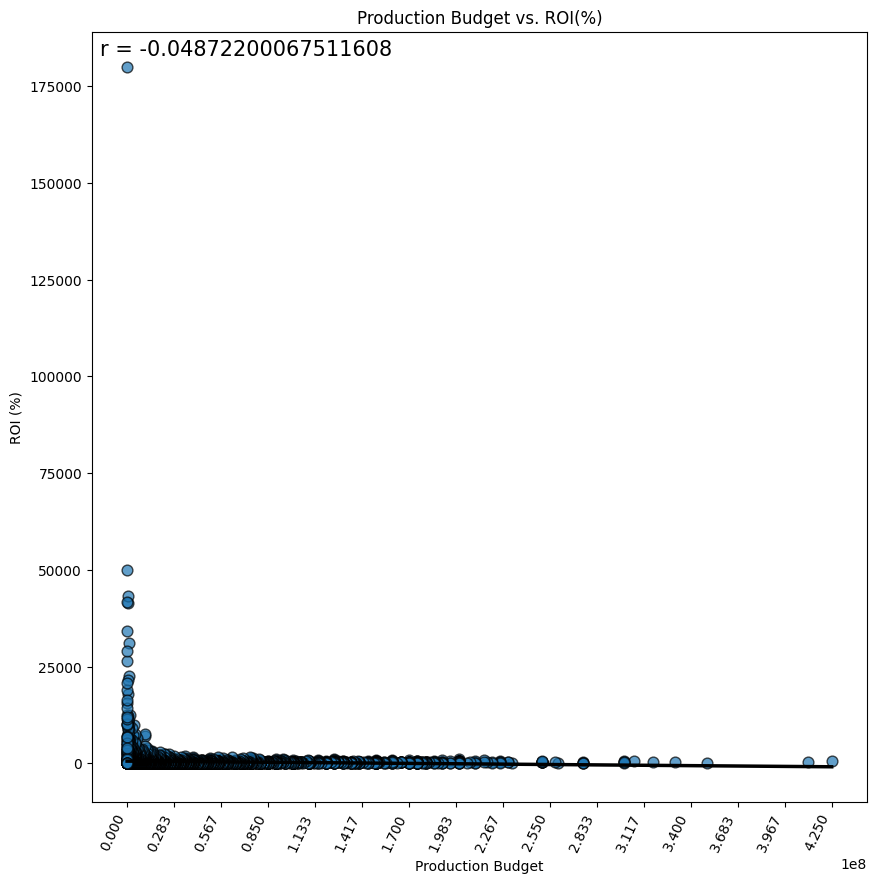

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

x = df['production_budget']
y = df['ROI_percent']

xlabel = "Production Budget"
ylabel = "ROI (%)"
title = "Production Budget vs. ROI(%)"

num_ticks = 15

xticks = np.arange(x.min(), x.max()+1, (x.max()-x.min())/num_ticks)

plt.xticks(
    xticks,
    rotation=65,
    horizontalalignment='right',
)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)

# Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(x.min(), x.max(), num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

# Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
correlation = np.corrcoef(x,y)[0,1]

ax.text(.01,
         .99, 
         "r = {}".format(str(correlation)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15)

ax.scatter(x, y, s=60, alpha=0.7, edgecolors='k');

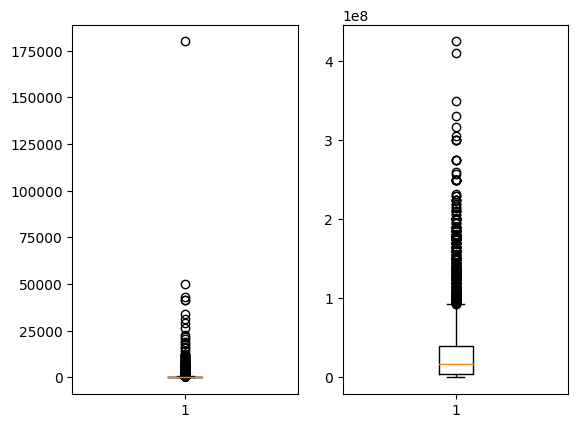

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(df['ROI_percent']);
ax[1].boxplot(df['production_budget']);

# Observations

This graph is completely uninformative due to the presence of numerous outliers in both variables. Boxplots of both production budget and ROI confirm the existence of outliers. In order to create a meaningful scatterplot, we will have to eliminate the outliers from our dataset.

We will use the IQR (interquartile range) to locate outliers. Initially we multiply the IQR by 1.5 and locate the 25th quartile (Q1) and 75th quartile (Q3). Q1 and Q3 show up on the boxplot as the edges of the box parallel to the median (yellow line). Any value less than Q1 - (IQR * 1.5) is an outlier; likewise for any value greater than Q3 + (IQR * 1.5).

We will write a function that returns a null value if a value is an outlier, and returns the original value if not. We will then map various columns on this function, and then use the .dropna() method on the resutling dataframe.

In [10]:
def is_outlier(x, df):

    q1, q3 = df.quantile([.25, .75])
    iqr = q3-q1
    
    lower_limit = q1 - (iqr*1.5)
    upper_limit = q3 + (iqr*1.5)
    
    if any([(x<lower_limit), (x>upper_limit)]):
        return np.nan
    else:
        return x

In [11]:
# Creating copy of data
no_outliers = df.copy()

to_clean = [
    'production_budget',
    'worldwide_gross',
    'ROI_percent'
]

for i in to_clean:
    no_outliers[i] = no_outliers[i].map(lambda x: is_outlier(x, no_outliers[i]))
    
for i in to_clean:
    print(no_outliers[i].isnull().value_counts())
    
no_outliers.dropna(inplace=True)

print("\n")
print("The previous dataframe had {} columns.".format(df.shape[0]))
print("The current dataframe has {} columns.".format(no_outliers.shape[0]))

False    5351
True      431
Name: production_budget, dtype: int64
False    5178
True      604
Name: worldwide_gross, dtype: int64
False    5287
True      495
Name: ROI_percent, dtype: int64


The previous dataframe had 5782 columns.
The current dataframe has 4695 columns.


Text(0.01, 0.99, 'r = 0.00969578954118254')

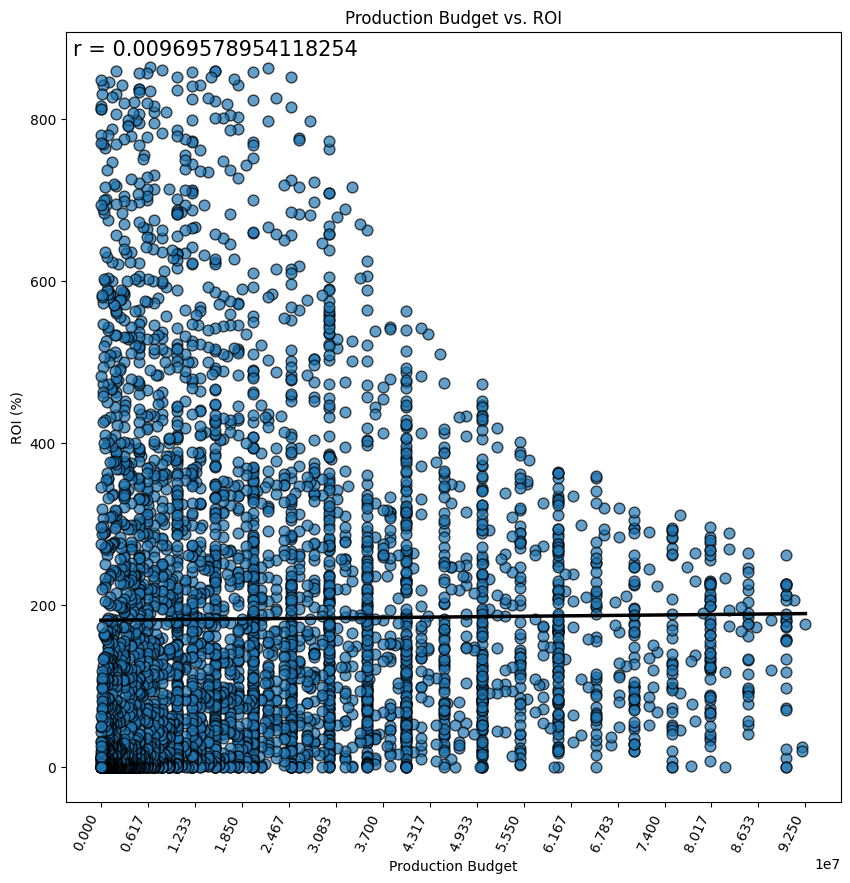

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

x = no_outliers['production_budget']
y = no_outliers['ROI_percent']

xlabel = "Production Budget"
ylabel = "ROI (%)"
title = "Production Budget vs. ROI"

num_ticks = 15

xticks = np.arange(x.min(), x.max()+1, (x.max()-x.min())/num_ticks)

plt.xticks(
    xticks,
    rotation=65,
    horizontalalignment='right',
)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)

ax.scatter(x, y, s=60, alpha=0.7, edgecolors='k');

# Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(x.min(), x.max(), num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

# Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
correlation = np.corrcoef(x,y)[0,1]

ax.text(.01,
         .99, 
         "r = {}".format(str(correlation)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15)

# Conclusion

From this graph, it seems like there is absolutely no connection between ROI and the return on the investment. The data points are spread evenly throughout the lower diagonal half of the graph; the trendline is almost perfectly horizontal, and the correlation coefficient is almost exactly 0. In fact, it is even slightly negative.

The data points seem to be trending downward but this does not translate to a correlation. The only reason this is happening is because it's harder to get higher ROI's with a higher budget. It's easier to hit an insanely high ROI with a small budget than it is with a large budget, thus the absence of data points in the top diagonal half of the graph.


# Adjusting for Inflation

Some of these movies go back to the early 1900's. If we adjust our budget and gross data for inflation, does it change our findings at all?

To adjust for inflation, we will need CPI data. That is gathered from this source: https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-

We will use the Python requests package to retrieve HTML data from this source and BeautifulSoup to parse the DOM and select specific HTML elements and their content.

In [13]:
html_page = requests.get('https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-') # Make a get request to retrieve the page
soup = bs(html_page.content, 'html.parser') # Pass the page contents to beautiful soup for parsing

In [14]:
table = soup.findAll('tbody')

In [15]:
rows = table[0].findAll('tr')

In [16]:
data = []

for i in range(len(rows)):
    try:
        a,b,c = [div.text for div in rows[i].findAll('div')]
        data.append([a,b,c])
    except:
        continue

In [17]:
data[-1] = ['\xa02022', '294.4', '8.6%']
data[0] = ['1913', '9.9', '0.0%']

In [18]:
cpi = {int(data[i][0]): float(data[i][1]) for i in range(len(data))}

In [19]:
years = list(df['release_date'])
budgets = list(df['production_budget'])
worldwide_grosses = list(df['worldwide_gross'])
domestic_grosses = list(df['domestic_gross'])

In [20]:
for i in range(len(years)):
    change = cpi[years[i]] / cpi[1914]
    inflation = change / cpi[1914]
    worldwide_grosses[i] = int(worldwide_grosses[i] * inflation)
    domestic_grosses[i] = int(domestic_grosses[i] * inflation)
    budgets[i] = int(budgets[i] * inflation)

In [21]:
# Updating data
df['worldwide_gross'] = worldwide_grosses
df['domestic_gross'] = domestic_grosses

df.dtypes

id                            int64
release_date                  int64
movie                        object
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
ROI_percent                   int64
production_budget_tier        int64
production_budget_dollars    object
dtype: object

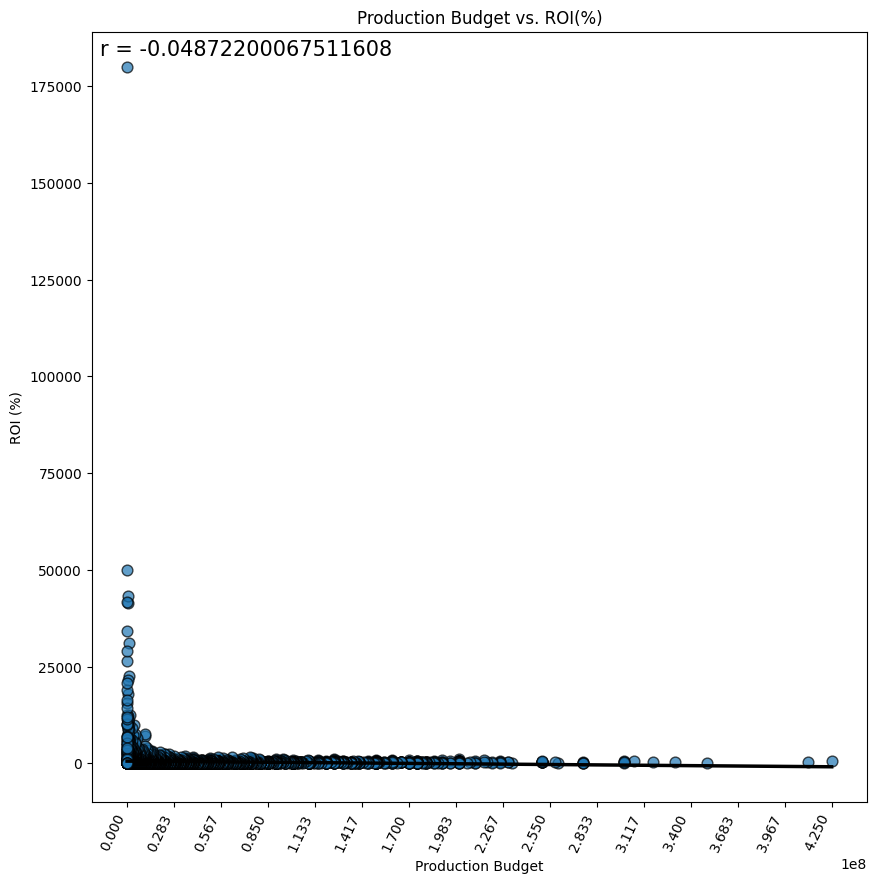

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

x = df['production_budget']
y = df['ROI_percent']

xlabel = "Production Budget"
ylabel = "ROI (%)"
title = "Production Budget vs. ROI(%)"

num_ticks = 15

xticks = np.arange(x.min(), x.max()+1, (x.max()-x.min())/num_ticks)

plt.xticks(
    xticks,
    rotation=65,
    horizontalalignment='right',
)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)

# Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(x.min(), x.max(), num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

# Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
correlation = np.corrcoef(x,y)[0,1]

ax.text(.01,
         .99, 
         "r = {}".format(str(correlation)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15)

ax.scatter(x, y, s=60, alpha=0.7, edgecolors='k');

In [23]:
# Creating copy of data
no_outliers = df.copy()

to_clean = [
    'production_budget',
    'worldwide_gross',
    'ROI_percent'
]

for i in to_clean:
    no_outliers[i] = no_outliers[i].map(lambda x: is_outlier(x, no_outliers[i]))
    
for i in to_clean:
    print(no_outliers[i].isnull().value_counts())
    
no_outliers.dropna(inplace=True)

print("\n")
print("The previous dataframe had {} columns.".format(df.shape[0]))
print("The current dataframe has {} columns.".format(no_outliers.shape[0]))

False    5351
True      431
Name: production_budget, dtype: int64
False    5168
True      614
Name: worldwide_gross, dtype: int64
False    5287
True      495
Name: ROI_percent, dtype: int64


The previous dataframe had 5782 columns.
The current dataframe has 4679 columns.


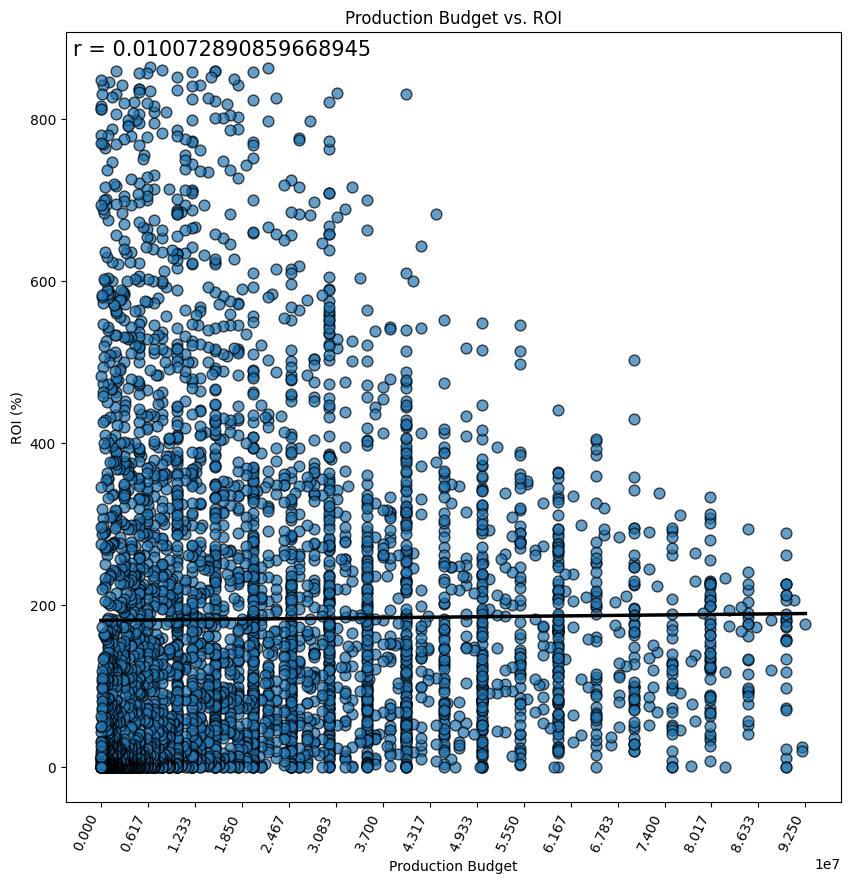

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

x = no_outliers['production_budget']
y = no_outliers['ROI_percent']

xlabel = "Production Budget"
ylabel = "ROI (%)"
title = "Production Budget vs. ROI"

num_ticks = 15

xticks = np.arange(x.min(), x.max()+1, (x.max()-x.min())/num_ticks)

plt.xticks(
    xticks,
    rotation=65,
    horizontalalignment='right',
)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)

ax.scatter(x, y, s=60, alpha=0.7, edgecolors='k');

# Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(x.min(), x.max(), num=100)
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

# Correlation line comes from https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
correlation = np.corrcoef(x,y)[0,1]

ax.text(.01,
         .99, 
         "r = {}".format(str(correlation)),
         ha='left',
         va='top',
         transform=ax.transAxes,
         fontsize = 15);

# Conclusion

Adjusting our data for inflation did nothing at all. Budget still bears no correlation to ROI. Before making any recommendations, however, there is one more question worth asking: what is the likelihood that a movie has an ROI over 100% (that is, becomes profitable) given the initial budget of the movie?

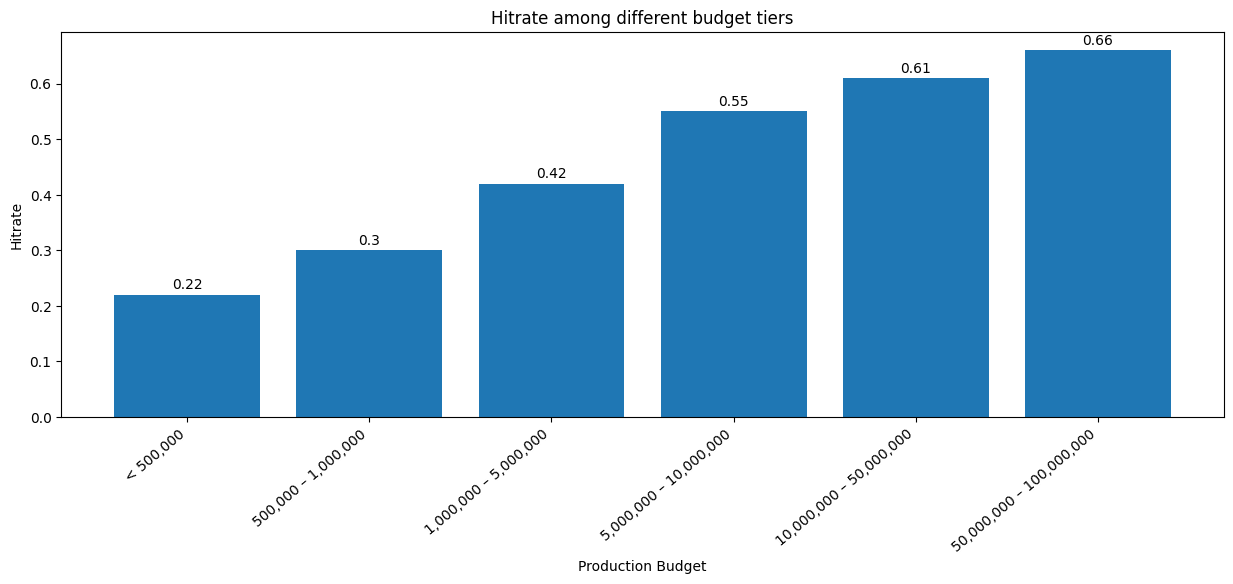

In [25]:
unique_tiers = sorted(list(no_outliers['production_budget_tier'].unique()))

y = [
    len (no_outliers[(no_outliers['production_budget_tier'] == i) & (no_outliers['ROI_percent'] > 100)]) /\
    len (no_outliers[(no_outliers['production_budget_tier'] == i)])\
    for i in unique_tiers

]
    
fig, ax = plt.subplots(figsize=(15,5))

title = "Hitrate among different budget tiers"
ax.set_title(title)

x = [i for i in tierranges[:max(unique_tiers)+1]]
y = [round(i, 2) for i in y]

barplot = ax.bar(x,y)

plt.xticks(
    x,
    rotation = 40,
    horizontalalignment = 'right',
)

plt.xlabel("Production Budget")
plt.ylabel("Hitrate")
ax.bar_label(barplot, labels=y, label_type='edge', padding=2);

# Conclusion

Although there is no relationship between budget and ROI, there is a relationship between budget and whether or not a movie is profitable. The bar graph above clearly demonstrates that the greater your budget, the higher the chance of your movie making it above 100% ROI.

Combining the result of our scatterplot and bar graph, I would recommend the executives at Microsoft make their budgets as high as they comfortably can.

In [26]:
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI_percent,production_budget_tier,production_budget_dollars
0,1,2009,Avatar,425000000,1631288855,5955260623,653,12,"> 400,000,000"
1,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,542152654,2351698054,254,12,"> 400,000,000"
2,3,2019,Dark Phoenix,350000000,109343328,382942328,42,11,"350,000,000 – 400,000,000"
3,4,2015,Avengers: Age of Ultron,330600000,1087843907,3325143092,424,10,"300,000,000 – 350,000,000"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,317000000,1520064567,3227285001,415,10,"300,000,000 – 350,000,000"
...,...,...,...,...,...,...,...,...,...
5777,78,2018,Red 11,7000,0,0,0,0,"< 500,000"
5778,79,1999,Following,6000,80771,400664,4008,0,"< 500,000"
5779,80,2005,Return to the Land of Wonders,5000,2613,2613,26,0,"< 500,000"
5780,81,2015,A Plague So Pleasant,1400,0,0,0,0,"< 500,000"


In [57]:
df['foreign_gross'] = df['worldwide_gross'] - df['domestic_gross']

In [32]:
df.domestic_gross.mean() / df.worldwide_gross.mean(),\
df.foreign_gross.mean() / df.worldwide_gross.mean(),\
df.foreign_gross.mean() / df.domestic_gross.mean()

(0.44126950600068965, 0.5587304939993104, 1.2661887721705318)

In [35]:
df['domestic_roi'] = df['domestic_gross'] / df['production_budget']

In [36]:
df['domestic_roi'].mean()

4.2035653004107925

In [51]:
df['profitable'] = df['ROI_percent'].map(lambda x: 1 if x > 100 else 0)

In [62]:
df.dtypes

id                             int64
release_date                   int64
movie                         object
production_budget              int64
domestic_gross                 int64
worldwide_gross                int64
ROI_percent                    int64
production_budget_tier         int64
production_budget_dollars     object
foreign_gross                  int64
domestic_roi                 float64
profitable                     int64
dtype: object

<AxesSubplot: xlabel='production_budget', ylabel='profitable'>

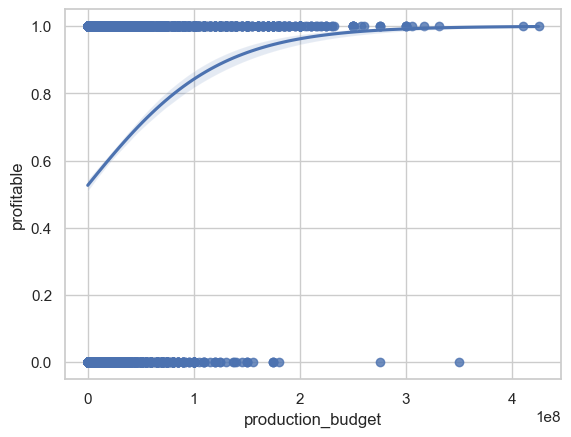

In [96]:
sns.regplot(data = df, x = 'production_budget', y = 'profitable', logistic=True)